<a href="https://colab.research.google.com/github/JuanM-GG/sistemas-dinamicos-R/blob/main/continuous_product_blending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Continuous Product Blending

Nombre: Juan Manuel

Fecha: 22 de diciembre del 2020

1. Cargar librerías

In [2]:
install.packages("deSolve")
library(deSolve)
install.packages("ggplot2")
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



2. Parameters values

It is a good practice to include all relevant parameter values in single block code.

In [3]:
caf <- 200 # g/L
Vmax <- 15000 # L
Vmin <- 8000 # L

# Process setpoints
ca_sp <- 8
rtime_sp <- 96

# Nominal values
qout_bar <- 125


3. Compute steady sates
A good modeling practice is to begin with the determination of a nominal steady sate. By nominal we mean operating conditions representative of typical, desired behavior of the process in question, and shoul be completed based on parameter values given above

In [4]:
# Nominal steady state at process setpoints
V_bar <- rtime_sp*qout_bar # D = V/q in a continuous reactor
ca_bar <- ca_sp # specification
qa_bar <-ca_sp*qout_bar/caf # balance of A 
qs_bar <- qout_bar - qa_bar # general balance

In [5]:
cat("Steady-State","\n")
cat("   V [L]   =",V_bar,"\n")
cat("   ca [g/L]   =",ca_bar,"\n")
cat("   qa [L/h]   =",qa_bar,"\n")
cat("   qs [L/h]   =",qs_bar,"\n")

Steady-State 
   V [L]   = 12000 
   ca [g/L]   = 8 
   qa [L/h]   = 5 
   qs [L/h]   = 120 


4. Process Model Equations

In our case the model consist of a system of two differential equations. For simulation with Python function `odeint`, the model is encapsulated into a Python function that accepts two arguments

`state` is a list of values for the model state, in this case `V` and `ca`

`t` is a variable containing value corresponding to the current time 

In [72]:
tank <- function(t,state,parms) {
  with(as.list(c(state,parms)),{

    dV = qa + qs - qout
    dca = qa*(caf - ca)/V - qs*ca/V

    return(list(c(dV,dca)))
  })
}

5. Numerical Solution of the Process Model

Here we establish values for all degrees of freedom, specify initial conditions, ann then proced to compute a history of the process behavior. The history is broken into discrete time step which is a bit more work now, but will later provide a means to test implementations of control algorithms.

For first simulation, it is usually a good idea to pick an initial condition that will yield a know result. In this case we start a simulation at steady state.

Fix all degrees of freedom

In [7]:
p <- c(qa = qa_bar, qs = qs_bar, qout = qout_bar, caf = caf)

Establish initial conditions 

In [8]:
s <- c(V = V_bar, ca = ca_bar)

Simulation time, and variables to store simulation record (or history)

In [9]:
t <- seq(0,500,len=500)
V <- rep(V_bar,length(t))
ca <- rep(ca_bar,length(t))

In [10]:
for (i in 1:(length(t) - 1)) {
  # Update simulation time
  ts <- c(t[i], t[i+1])

  # Solve ODEs
  out <- ode(y = s, times = ts, func = tank, parms = p, method = "rk4")
  n <- nrow(out)

  # Update initial conditions
  s <- out[n,c(2,3)]

  # Save state
  V[i+1] <- out[n,2]
  ca[i+1] <- out[n,3]
}

Save results

In [11]:
data <- data.frame(t=t,ca=ca,V=V)

Show results

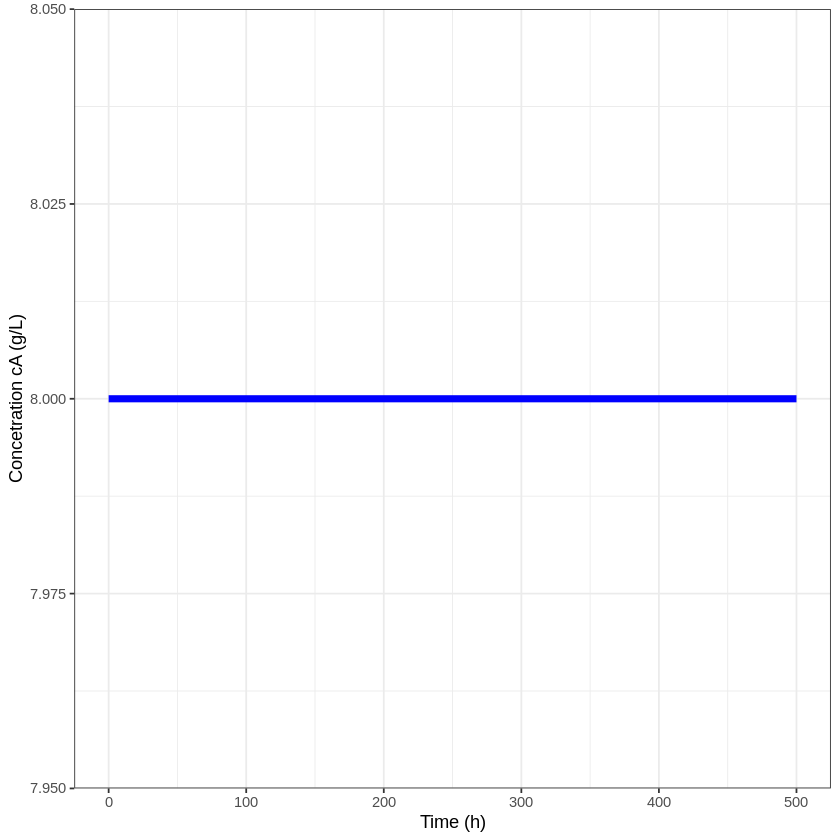

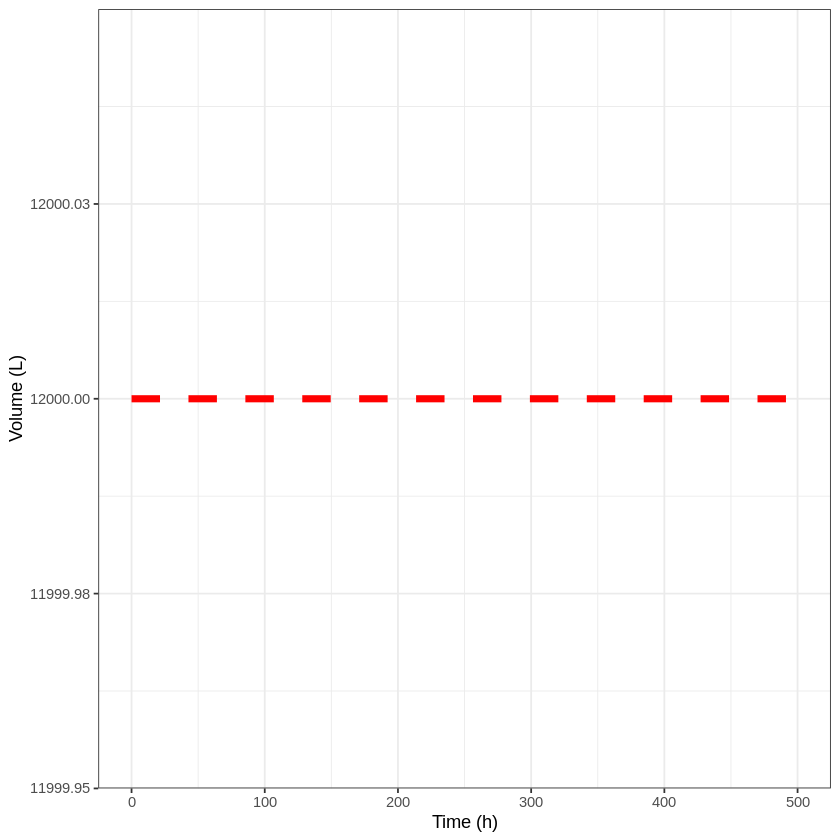

In [12]:
ggplot(data,aes(t,ca)) +
        geom_line(color = "blue", lwd = 2) +
        ylab("Concetration cA (g/L)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,V)) +
        geom_line(color = "red", lwd = 2, lty = 2) +
        ylab("Volume (L)") +
        xlab("Time (h)") +
        theme_bw()

## Explore Dynamical Behavior

Let's explore the behavior of this mixing tank under different assumptions. We'll explore the following cases:

1. The startup concentration of A is $c_A = 0$. How long before the mixer is producing an acceptable product?

2. The outlet flow increases by 10%. How long before the product is out of spec?

3. The outlet flow decreases by 10%. How long before the product is out of spec?

Fix all degrees of freedom

In [13]:
p <- c(qa = qa_bar, qs = qs_bar, qout = qout_bar, caf = caf)

Establish initial conditions

In [14]:
ca0 <- 0 # <==============================CHANGED TO AN INITIAL CONDITION OF ZERO
s <- c(V = V_bar, ca = ca0)

Simulation time, and variables to store simulation record (or history)

In [15]:
t <- seq(0,500,len = 500)
V <- rep(V_bar,length(t))
ca <- rep(ca0,length(t))

In [16]:
for(i in 1:(length(t)-1)) {
  
  # Simulation time
  ts <- c(t[i],t[i+1])

  # Solve ODEs
  out <- ode(y = s, times = ts,func = tank,parms = p,method = "rk4")
  n <- nrow(out)

  # Update initial conditons
  s <- out[n,c(2,3)]

  # Save state
  V[i+1] <- out[n,2]
  ca[i+1] <- out[n,3]
}

Save results

In [17]:
data <- data.frame(t=t,ca=ca,V=V)

Show results 

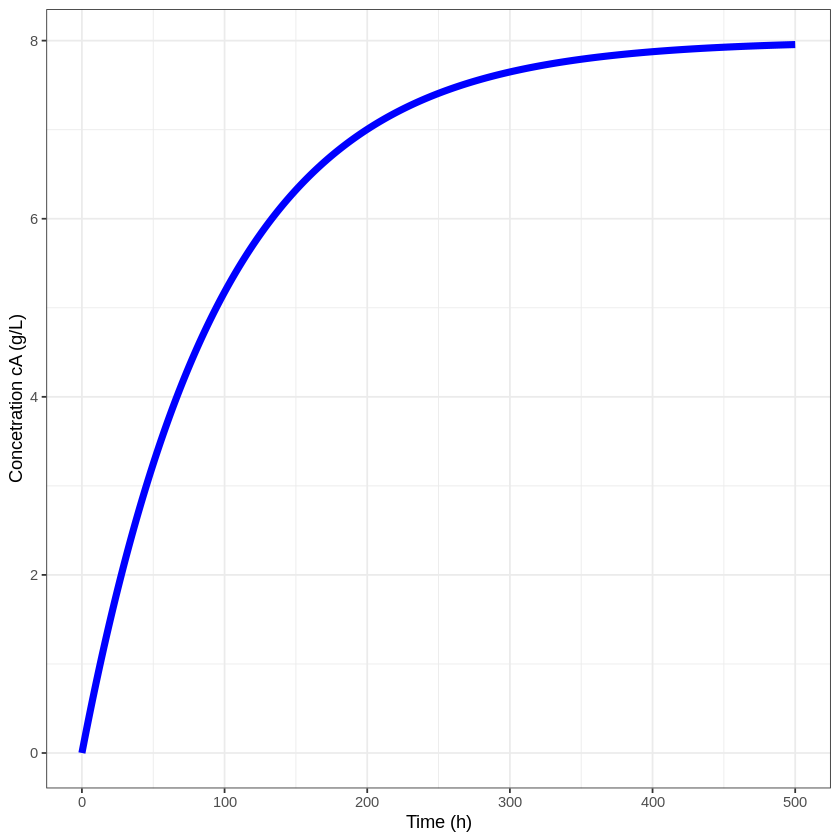

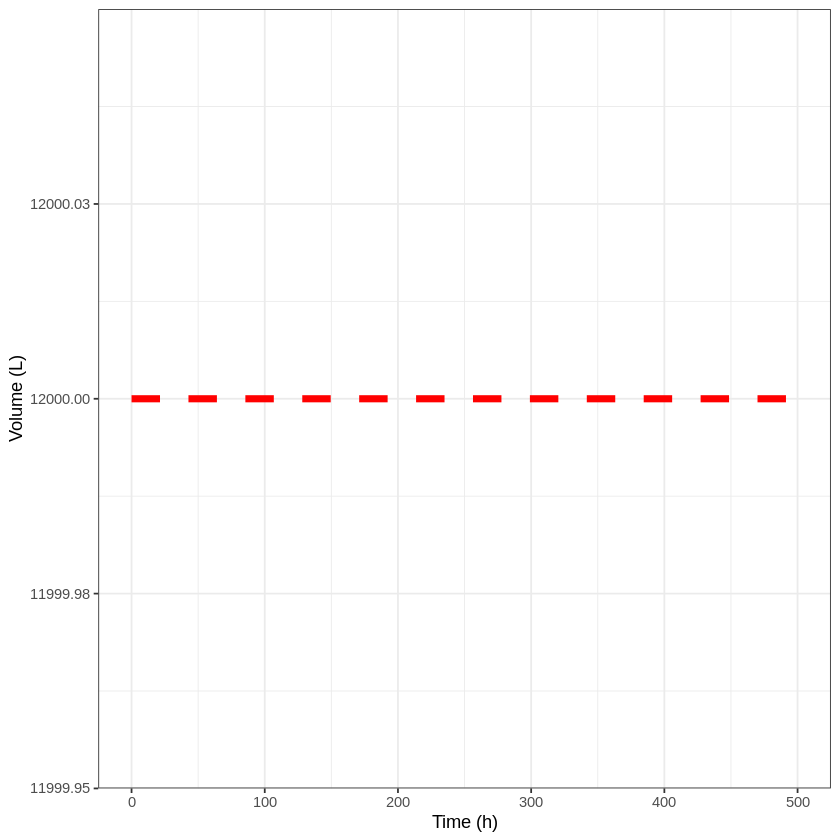

In [18]:
ggplot(data,aes(t,ca)) +
        geom_line(color = "blue", lwd = 2) +
        ylab("Concetration cA (g/L)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,V)) +
        geom_line(color = "red", lwd = 2, lty = 2) +
        ylab("Volume (L)") +
        xlab("Time (h)") +
        theme_bw()

It takes like 500 hours to reach the setpoint $c_A$ value

## Control Residence Time

From the exercises above, we know even small changes in the outlet flowrate results in suboptimal loss due to out-of-spec product. Let's try a control strategy in which we change the suspension flowrate,$q_S$, to compensate for excursions from the desired value of residence time.

We'll try proportional controlwhere the change in $q_S$ is proportional to the difference of the residence time from the setpoint

$$q_S = \bar{q}_S - K_p \left( \frac{V}{q_{out}} - \frac{\bar{V}}{\bar{q}_{out}} \right) $$

The negative sign is there because we expect a negative deviation in flowrate is needed to compensate for a positive deviations in residence time.

In the following cell we will decrease $q_{out}$ 10%, and attemp to find a value for $K$ that provides satisfactory control.

Fix all degrees of freedom

In [73]:
p <- c(qa = qa_bar, qs = qs_bar, qout = qout_bar, caf = caf)

Establish initial conditions

In [74]:
s <- c(V = V_bar, ca = ca_bar)

Simulation time, and variables to store simulation record (or history)

In [75]:
t <- seq(0,500,len=500)
V <- rep(V_bar, length(t))
ca <- rep(ca_bar, length(t))
Vqout <- rep(V_bar/qout_bar, length(t))
qs <- rep(qs_bar, length(t))

Decrease qout by 10%

In [76]:
qout <- 0.9*qout_bar
p["qout"] <- qout

In [77]:
for(i in 1:(length(t)-1)) {

  # Update simulation time
  ts <- c(t[i], t[i+1])

  # Update qs (proportional control)
  qs[i+1] <- qs_bar - 5*(Vqout[i] - V_bar/qout_bar)
  p["qs"] <- qs[i+1]
  
  # Solve ODEs 
  out <- ode(y = s, times = ts,func = tank, parms = p, method = "rk4")
  n <- nrow(out)

  # Update initial conditions
  s <- out[n,c(2,3)]

  # Update state
  V[i+1] <- out[n,2]
  ca[i+1] <- out[n,3]
  Vqout[i+1] <- V[i+1]/qout

}

Save results

In [78]:
data <- data.frame(t = t, ca = ca, V = V, Vqout = Vqout, qs = qs)

Show results

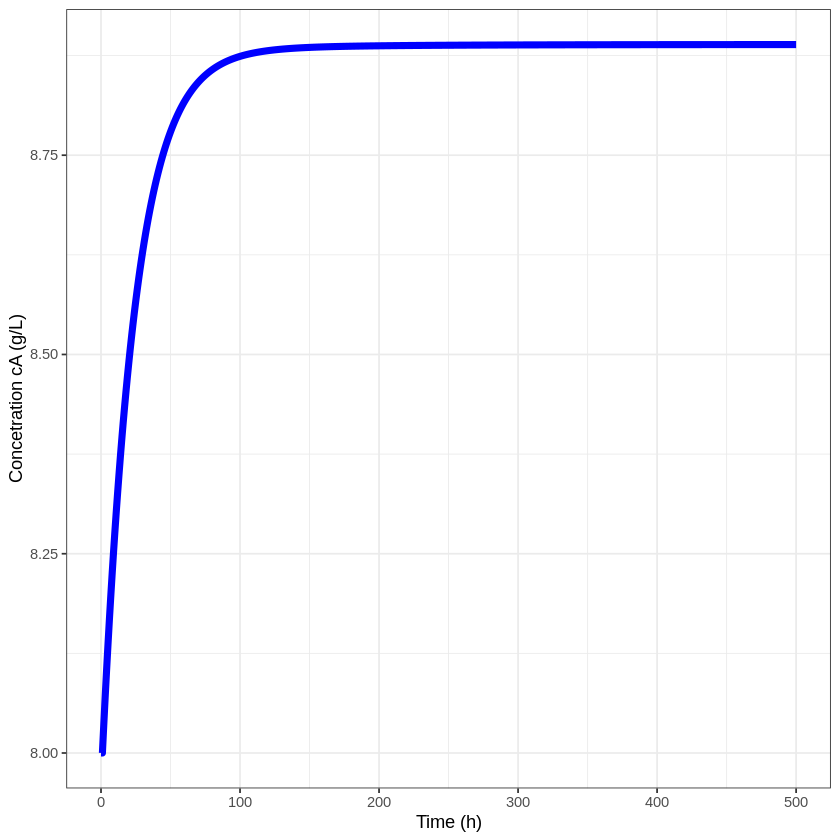

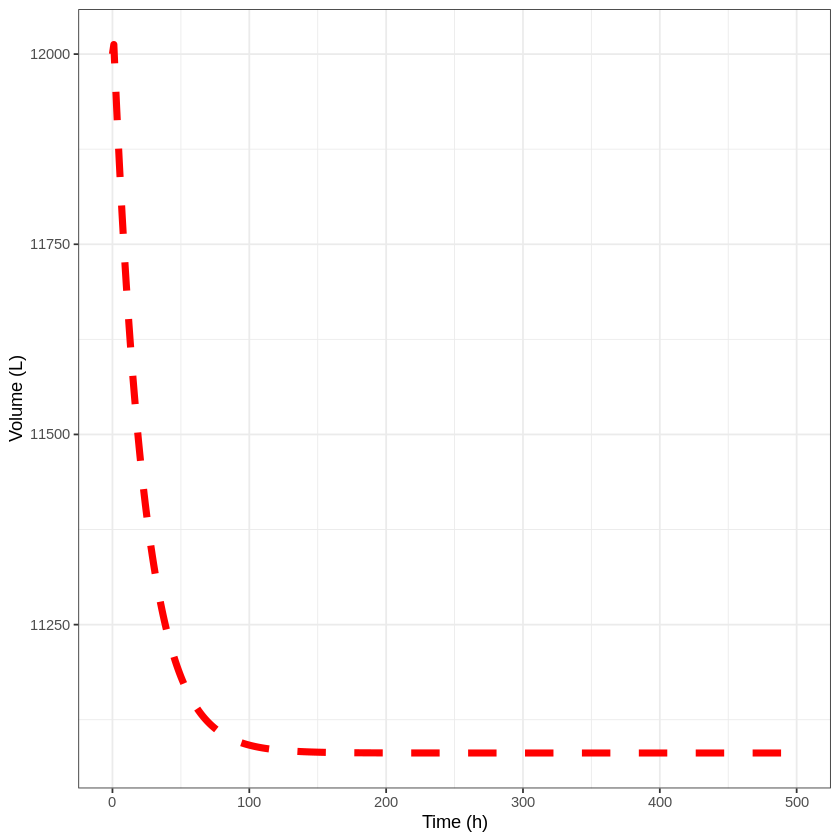

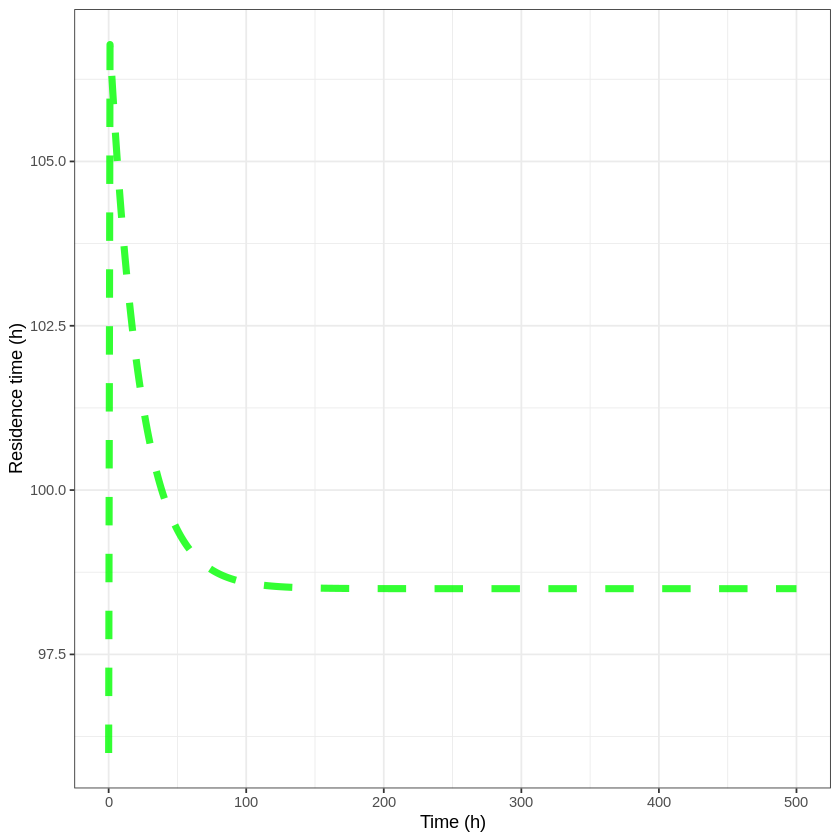

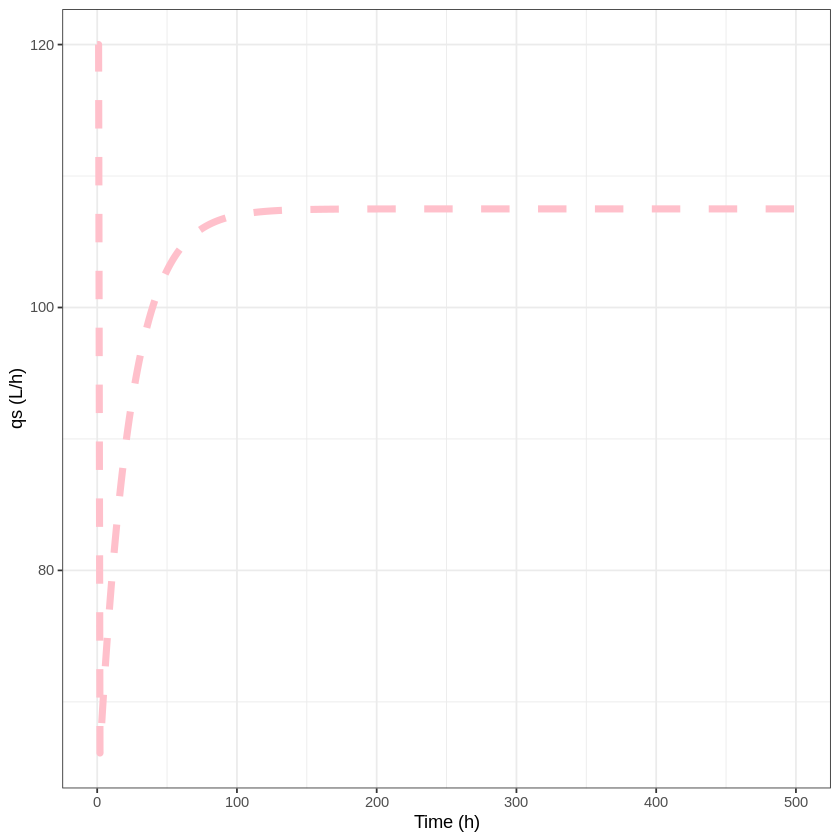

In [79]:
ggplot(data,aes(t,ca)) +
        geom_line(color = "blue", lwd = 2) +
        ylab("Concetration cA (g/L)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,V)) +
        geom_line(color = "red", lwd = 2, lty = 2) +
        ylab("Volume (L)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,Vqout)) +
        geom_line(color = "green", lwd = 2, lty = 2, alpha = 0.8) +
        ylab("Residence time (h)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,qs)) +
        geom_line(color = "pink", lwd = 2, lty = 2) +
        ylab("qs (L/h)") +
        xlab("Time (h)") +
        theme_bw()

## Control Concentration 

As show above, it isn't enough to control only residence time. In fact, controlling residence time in response to a decrease in output causes the outlet concentration to increase beyond the product quality limits. We propose to fix this problem by controlling $q_A$, the inlet flow of A. A proportional control rule is given by

$$q_A = \bar{q}_A - K_p \left( c_A - \bar{c}_A \right) $$

Where, again, we predict a decrease in $q_A$ is needed to compensate for a positive excursion of freedom

Fix all degrees of freedom

In [36]:
p <- c(qa = qa_bar, qs = qs_bar, qout = qout_bar, caf = caf)

qa   qs qout  caf 
   5  120  125  200

Establish initial conditions 

In [38]:
s <- c(V = V_bar, ca = ca_bar)

V    ca 
12000     8

Simulation time, and varaibles to store simulation record (or history)

In [39]:
t <- seq(0,500,len = 500)
V <- rep(V_bar,length(t))
ca <- rep(ca_bar,length(t))
Vqout <- rep(V_bar/qout_bar, length(t))
qs <- rep(qs_bar, length(t))
qa <- rep(qa_bar, length(t))

Decrease qout by 10%

In [40]:
qout <- 0.9*qout_bar
p["qout"] <- qout

In [41]:
for(i in 1:(length(t) - 1)) {
        
        # Update simulation time
        ts <- c(t[i], t[i+1])
        
        # Update qs (proportional control)
        qs[i+1] <- qs_bar - 5*(Vqout[i] - V_bar/qout_bar)
        p["qs"] <- qs[i+1]
        
        # Update qa (proportional contro)
        qa[i+1] <- qa_bar - 3*(ca[i] - ca_bar)
        p["qa"] <- qa[i+1]
        
        # Solve ODEs
        out <- ode(y = s,times = ts,func = tank,parms = p,method = "rk4")
        n <- nrow(out)
        
        # Update initial conditions
        s <- out[n,c(2,3)]
        
        # Update state
        V[i+1] <- out[n,2]
        ca[i+1] <- out[n,3]
        Vqout[i+1] <- V[i+1]/qout
}

Save results 

In [42]:
data <- data.frame(t = t, ca = ca, V = V, Vqout = Vqout, qs = qs, qa = qa)

Show results 

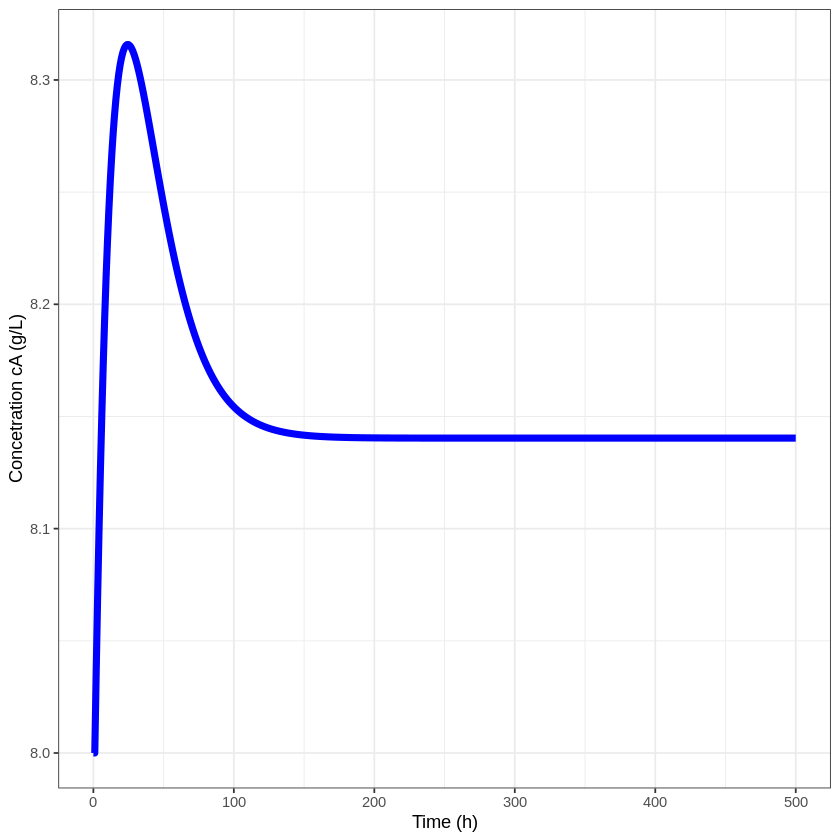

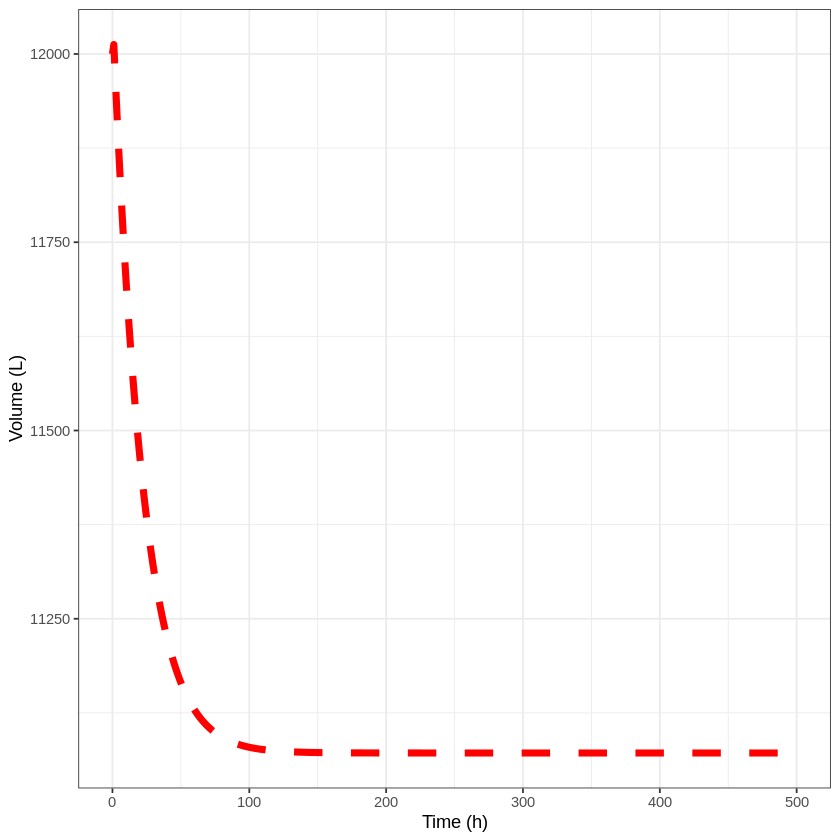

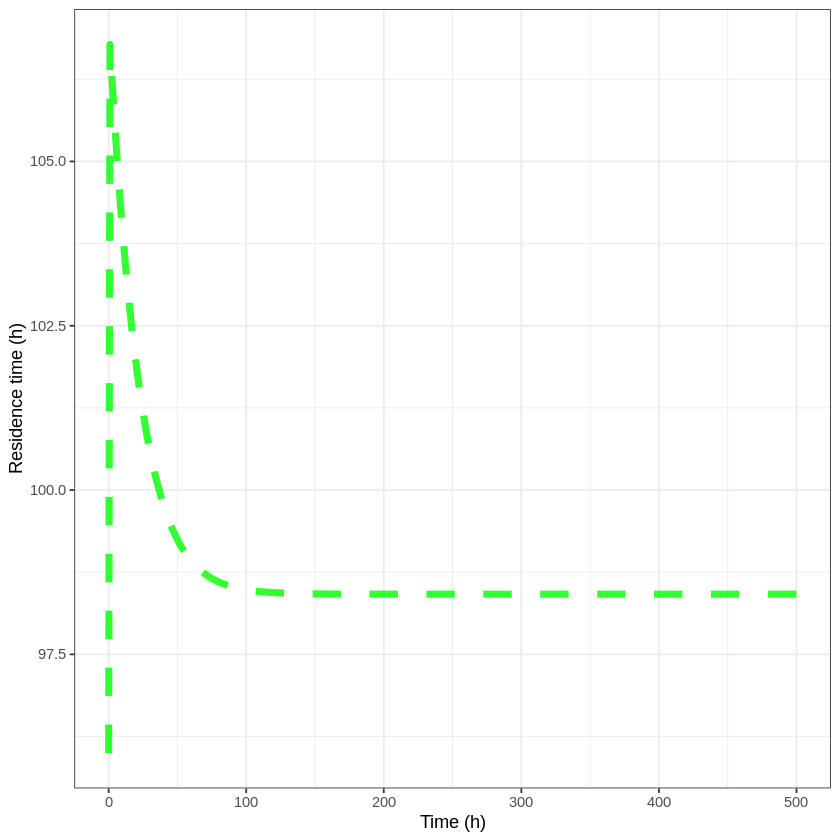

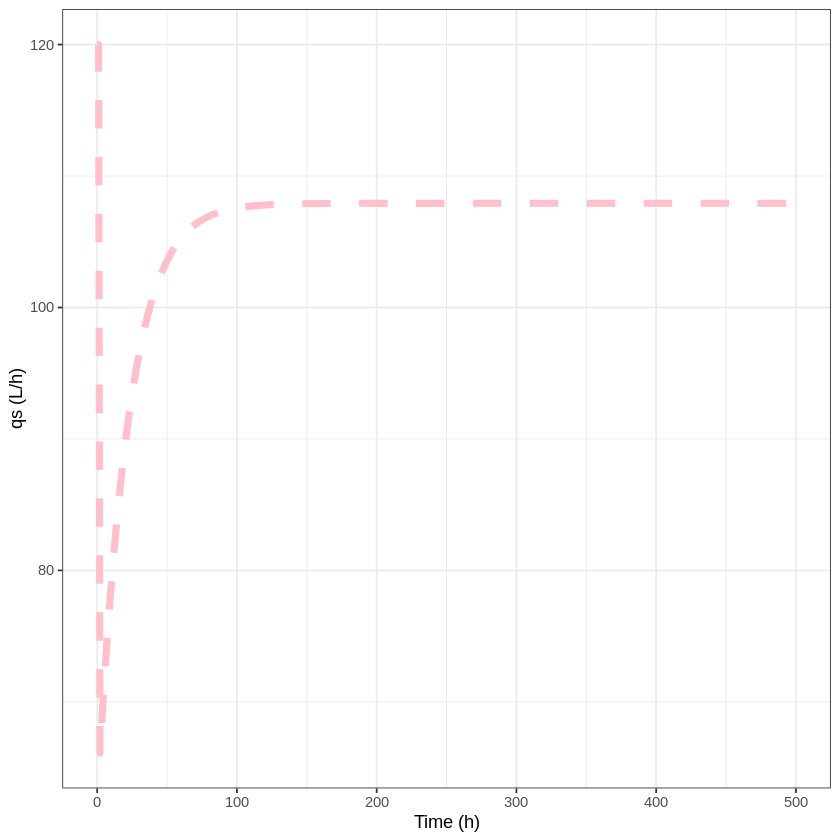

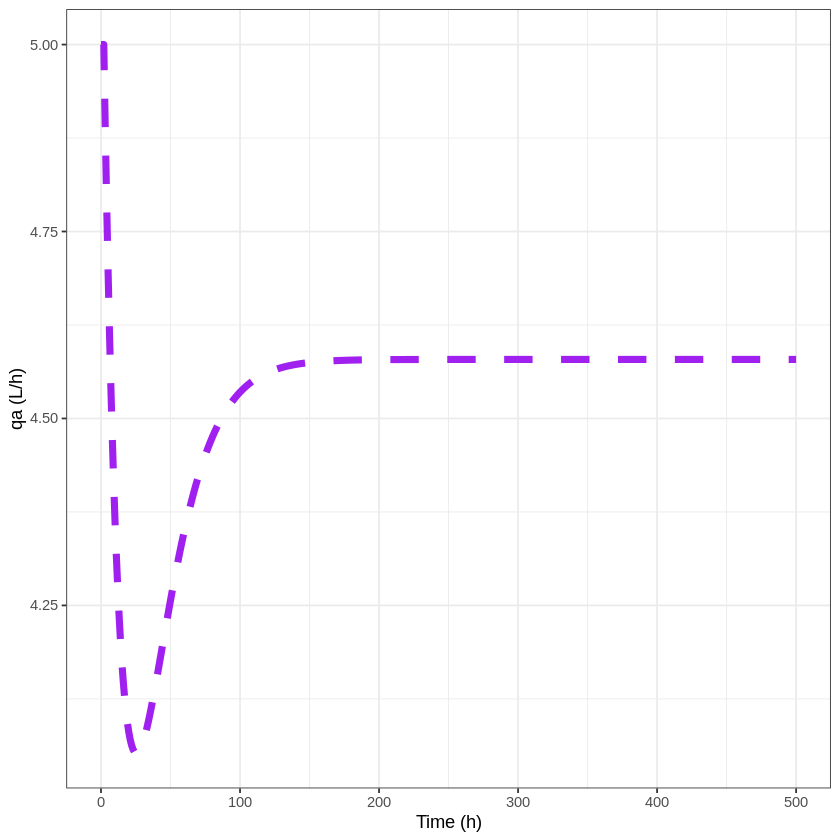

In [43]:
ggplot(data,aes(t,ca)) +
        geom_line(color = "blue", lwd = 2) +
        ylab("Concetration cA (g/L)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,V)) +
        geom_line(color = "red", lwd = 2, lty = 2) +
        ylab("Volume (L)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,Vqout)) +
        geom_line(color = "green", lwd = 2, lty = 2, alpha = 0.8) +
        ylab("Residence time (h)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,qs)) +
        geom_line(color = "pink", lwd = 2, lty = 2) +
        ylab("qs (L/h)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,qa)) +
        geom_line(color = "purple", lwd = 2, lty = 2) +
        ylab("qa (L/h)") +
        xlab("Time (h)") +
        theme_bw()

## Proprtional-Integral Control

The above control laws do a reasonable job of control, but do not return the system to a desired steady-state operating condition. How can we modify the control laws?

$$q_A = \bar{q}_A - K_p \left( c_A - \bar{c}_A  \right) - K_i \int_{0}^{t} \left( c_A - \bar{c}_A \right) dt$$

The second term will integrate any constant offset to produce a constantly changing value. So the only possible steady state is when $c_A = \bar{c}_A$. 

Fix all degrees of freedom

In [111]:
p <- c(qa = qa_bar, qs = qs_bar, qout = qout_bar, caf = caf)

Establish initial conditions 

In [112]:
s <- c(V = V_bar, ca = ca_bar)
error_sum <- 0
dt <- 1

Simulation time, and variables to store simulation record (or history)

In [113]:
t <- seq(0,500,len = 500)
V <- rep(V_bar, length(t))
ca <- rep(ca_bar, length(t))
Vqout <- rep(V_bar/qout_bar, length(t))
qs <- rep(qs_bar, length(t))
qa <- rep(qa_bar, length(t))

Decrease $q_{out}$ by 10%

In [114]:
qout <- 0.9*qout_bar
p["qout"] <- qout

In [115]:
for (i in 1:(length(t) - 1)) {
        
        # Update qs (Proportional control)
        qs[i+1] <- qs_bar - 5*(Vqout[i] - V_bar/qout_bar)
        p["qs"] <- qs[i+1]
        
        error <- (ca[i] - ca_bar)
        error_sum <- error_sum + error*dt
        
        # Update qa (PI control)
        qa[i+1] <- qa_bar - 3*error - 0.4*error_sum
        p["qa"] <- qa[i+1]
        
        # Update simulation time
        ts <- c(t[i], t[i+1])

        # Solve ODEs
        out <- ode(y = s,times = ts,func = tank, parms = p, method = "rk4")
        n <- nrow(out)
        
        # Update initial conditions
        s <- out[n,c(2,3)]
        
        # Save state
        V[i+1] <- out[n,2]
        ca[i+1] <- out[n,3]
        Vqout[i+1] <- V[i+1]/qout
        
}

Save results 

In [116]:
data <- data.frame(t = t, ca = ca, V = V, Vqout = Vqout, qs = qs, qa = qa)

Show results 

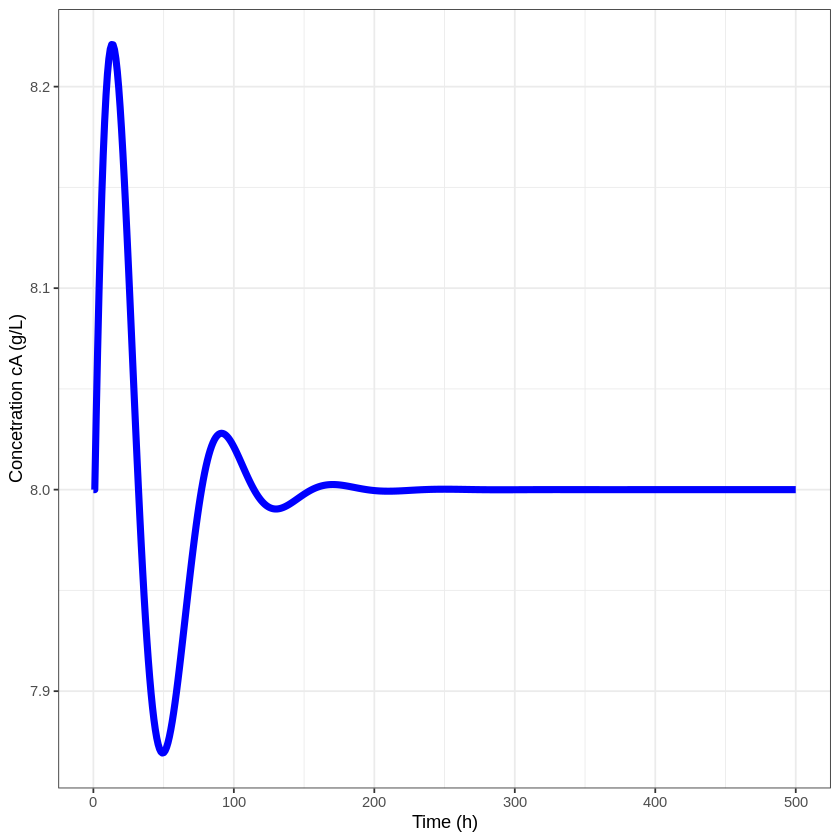

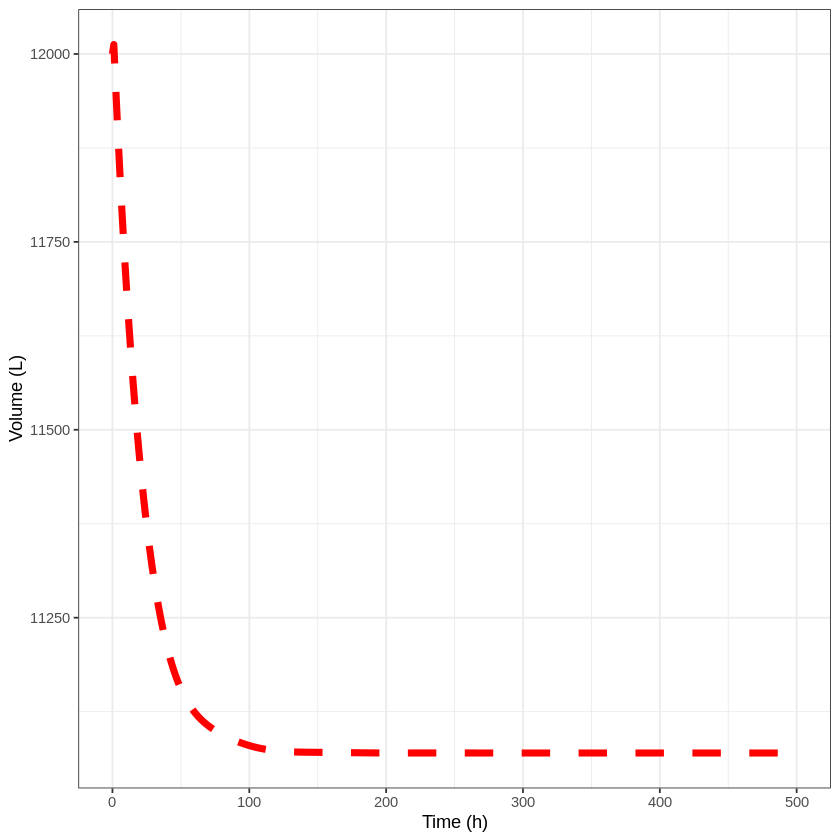

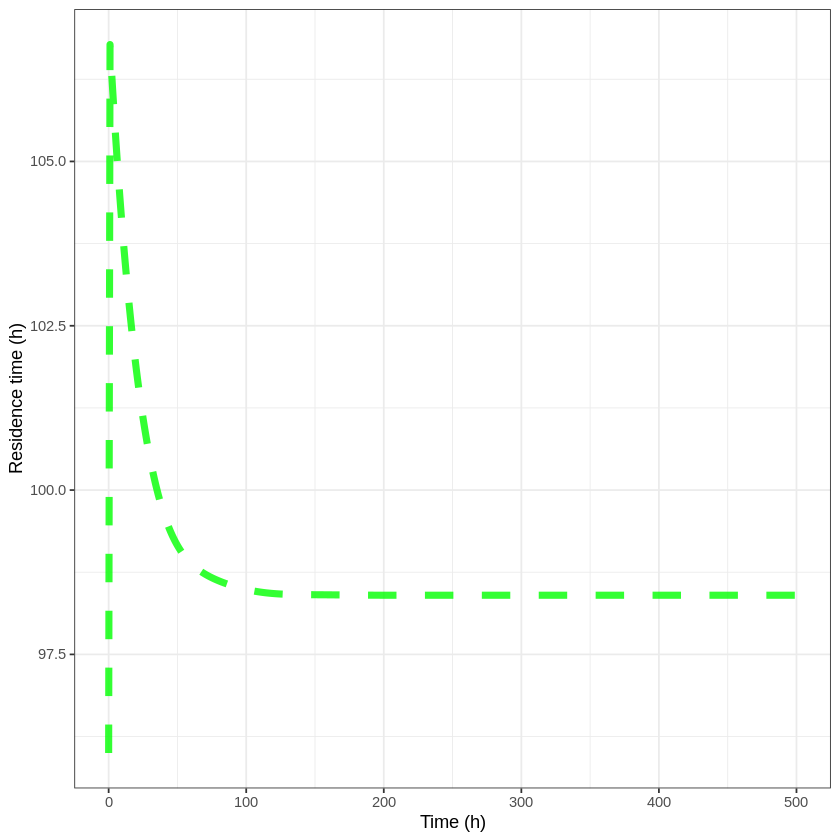

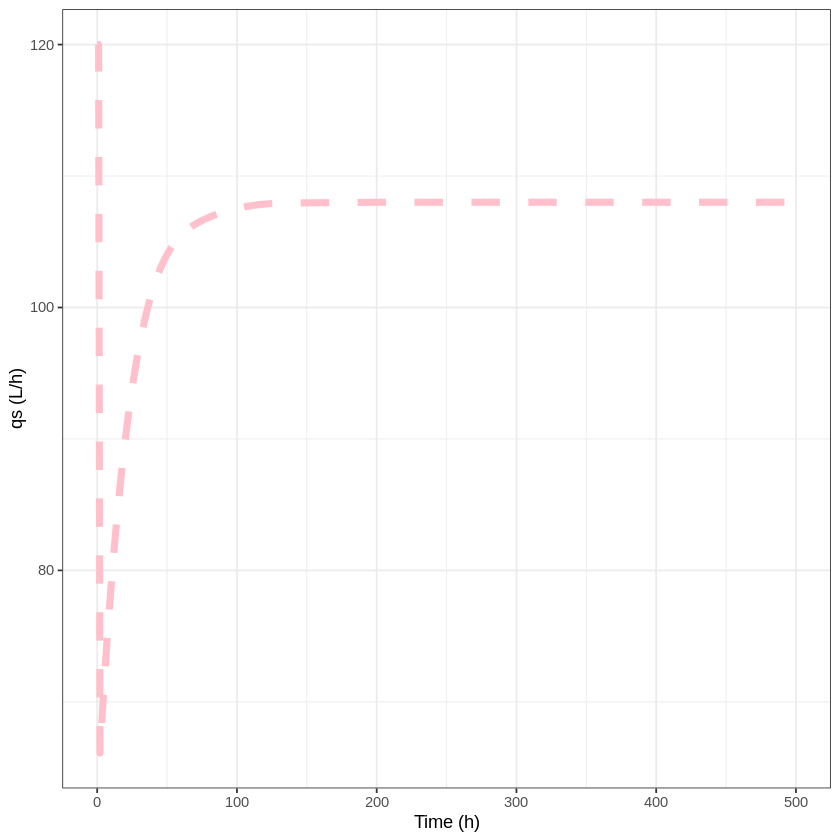

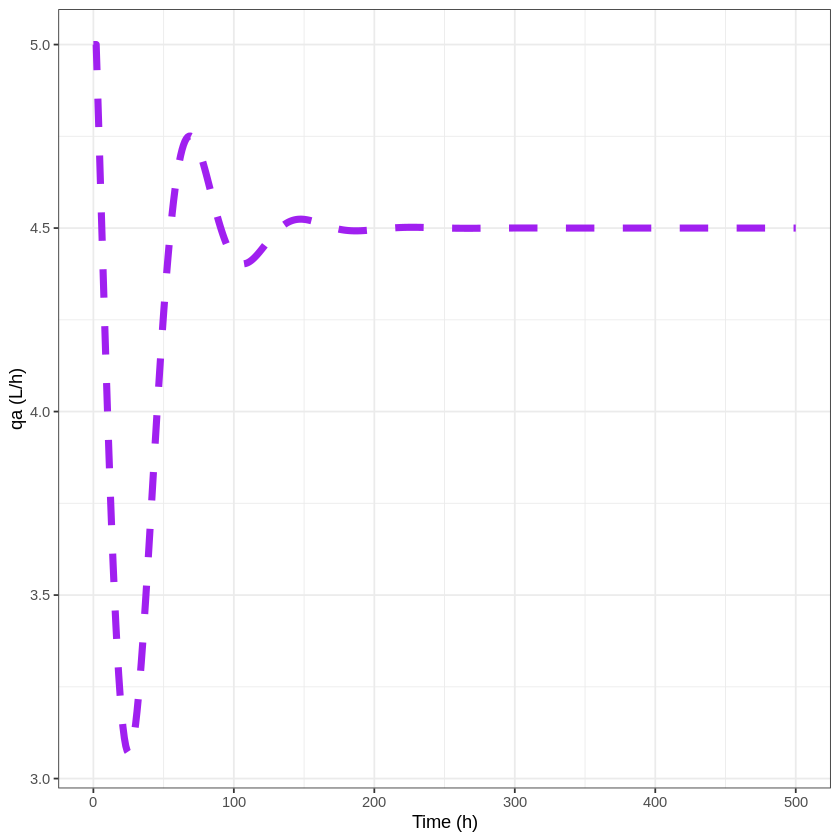

In [117]:
ggplot(data,aes(t,ca)) +
        geom_line(color = "blue", lwd = 2) +
        ylab("Concetration cA (g/L)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,V)) +
        geom_line(color = "red", lwd = 2, lty = 2) +
        ylab("Volume (L)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,Vqout)) +
        geom_line(color = "green", lwd = 2, lty = 2, alpha = 0.8) +
        ylab("Residence time (h)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,qs)) +
        geom_line(color = "pink", lwd = 2, lty = 2) +
        ylab("qs (L/h)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,qa)) +
        geom_line(color = "purple", lwd = 2, lty = 2) +
        ylab("qa (L/h)") +
        xlab("Time (h)") +
        theme_bw()

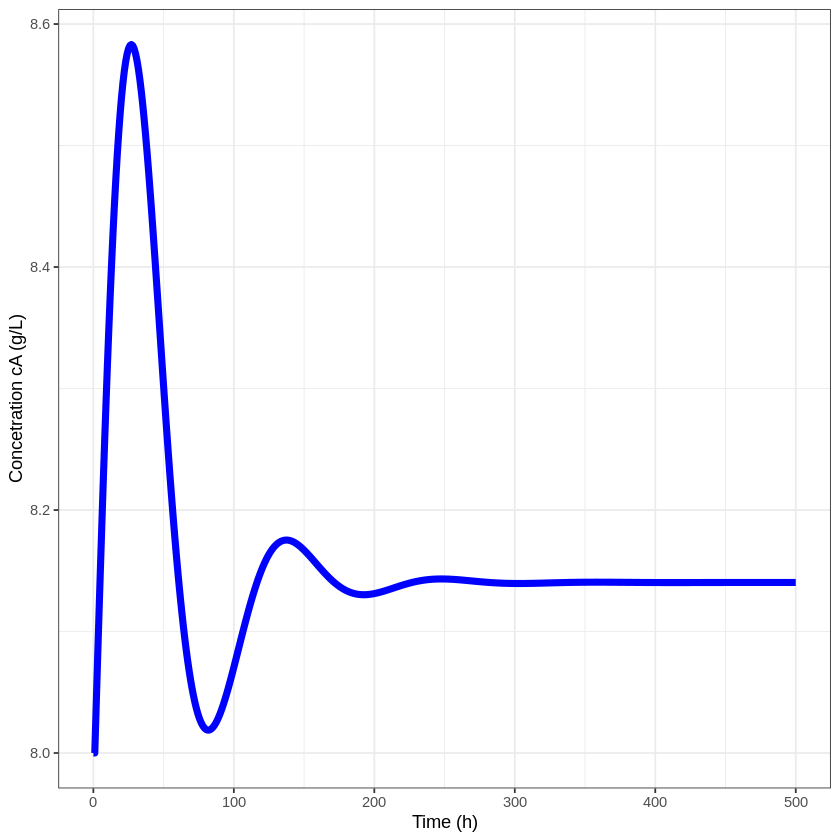

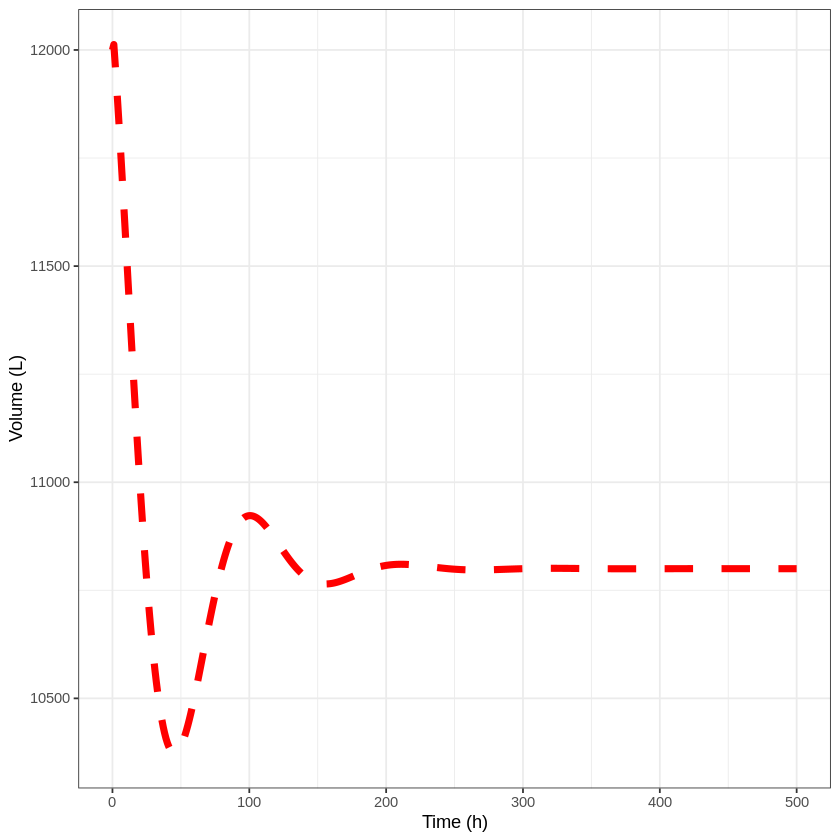

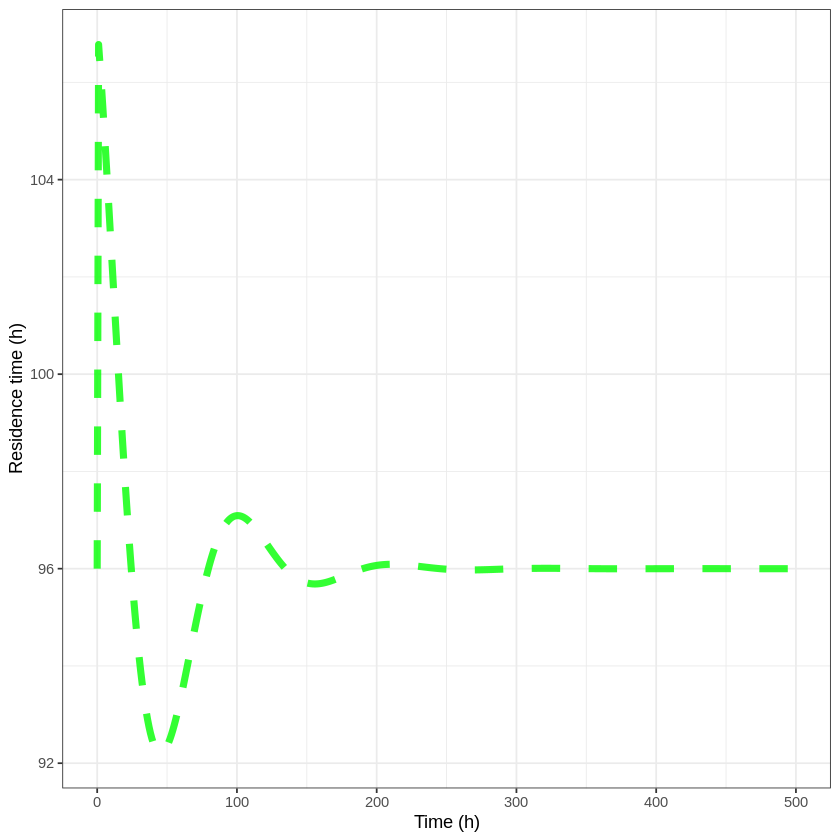

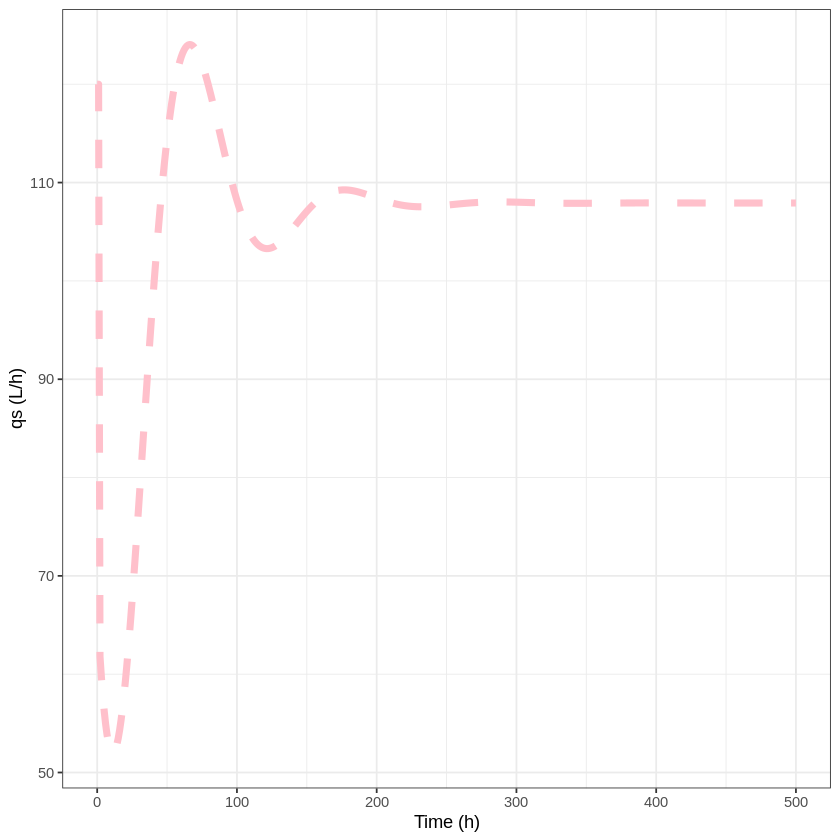

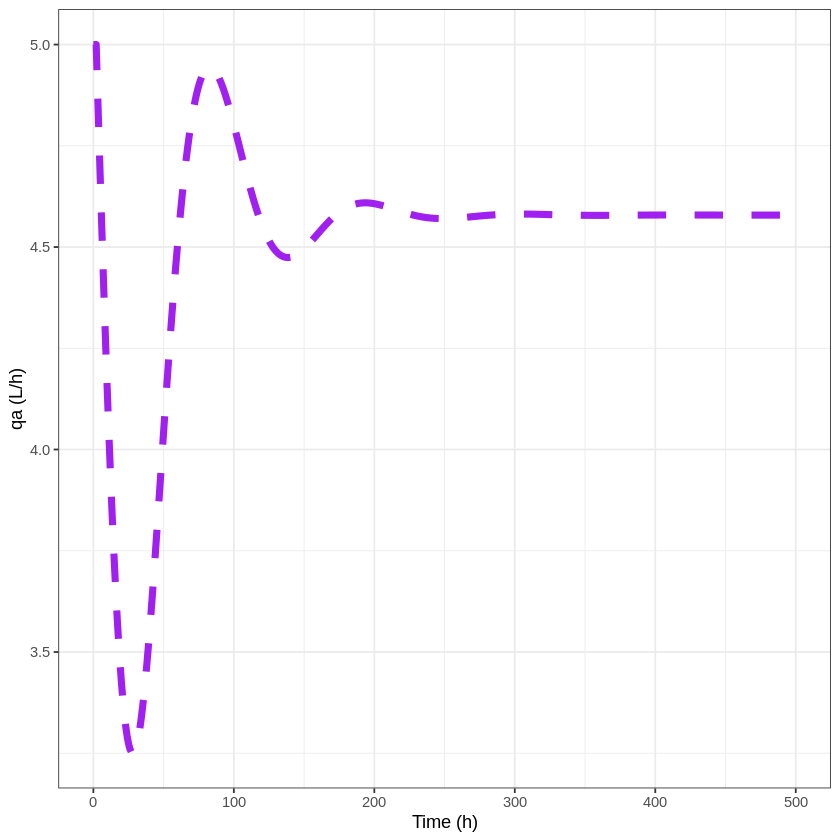

In [118]:
# Fix all degrees of freedom
p <- c(qa = qa_bar, qs = qs_bar, qout = qout_bar,caf = caf)

# Establish initial conditions
s <- c(V = V_bar, ca = ca_bar)
error_sum <- 0
dt <- 1

# Simulation time, and variables to store simulation record (or history)
t <- seq(0,500,len = 500)
V <- rep(V_bar, length(t))
ca <- rep(ca_bar, length(t))
Vqout <- rep(V_bar/qout_bar, length(t))
qs <- rep(qs_bar, length(t))
qa <- rep(qa_bar, length(t))

# Decrease qout by 10%
qout <- 0.9*qout_bar
p["qout"] <- qout

for (i in 1:(length(t) - 1)) {
        
        # Update simulation time
        ts <- c(t[i], t[i+1])
        
        # Update qa (proportional control)
        qa[i+1] <- qa_bar - 3*(ca[i] - ca_bar) 
        p["qa"] <- qa[i+1]
        
        error <- (Vqout[i] - V_bar/qout_bar)
        error_sum <- error_sum + error*dt
        
        # Update qs (PI control)
        qs[i+1] <- qs_bar - 5*error - 0.4*error_sum
        p["qs"] <- qs[i+1]
        
        # Solve ODEs 
        out <- ode(y = s, times = ts, func = tank, parms = p, method = "rk4")
        n <- nrow(out)
        
        # Update initial conditions
        s <- out[n,c(2,3)]
        
        # Save state
        V[i+1] <- out[n,2]
        ca[i+1] <- out[n,3]
        Vqout[i+1] <- V[i+1]/qout
        
}

# Save results
data <- data.frame(t = t, ca = ca, V = V, Vqout = Vqout, qs = qs, qa = qa)

# Show resutls
ggplot(data,aes(t,ca)) +
        geom_line(color = "blue", lwd = 2) +
        ylab("Concetration cA (g/L)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,V)) +
        geom_line(color = "red", lwd = 2, lty = 2) +
        ylab("Volume (L)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,Vqout)) +
        geom_line(color = "green", lwd = 2, lty = 2, alpha = 0.8) +
        ylab("Residence time (h)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,qs)) +
        geom_line(color = "pink", lwd = 2, lty = 2) +
        ylab("qs (L/h)") +
        xlab("Time (h)") +
        theme_bw()

ggplot(data,aes(t,qa)) +
        geom_line(color = "purple", lwd = 2, lty = 2) +
        ylab("qa (L/h)") +
        xlab("Time (h)") +
        theme_bw()